In [1]:
from netCDF4 import MFDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import datetime
import xarray
from mpas_xarray import preprocess_mpas, remove_repeated_time_index
from mpl_toolkits.basemap import Basemap

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 10) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
import glob
infiles=sorted(glob.glob('/lustre/scratch3/turquoise/lvanroekel/ACME/cases/SolarTest/run/mpaso.hist.am.timeSeriesStatsMonthly.0004*.nc'))

In [6]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

In [7]:
#load mesh
dsBase = xarray.open_dataset('/lustre/scratch3/turquoise/lvanroekel/ACME/cases/SolarTest/run/mpaso.hist.0004-01-01_00000.nc')

In [8]:
#infiles='/lustre/atlas1/cli115/scratch/vanroek/GMPAS-IAF_oRRS18to6v3_CIME53/run/mpaso.hist.am.timeSeriesStatsMonthly.003*.nc'
dsGcase = xarray.open_mfdataset(infiles, preprocess=lambda x: preprocess_mpas(x,yearoffset=1850,  \
                                                                    timestr=['xtime_startMonthly','xtime_endMonthly'], 
                                                                          onlyvars=['timeMonthly_avg_activeTracersSurfaceFlux_salinitySurfaceFlux', \
                                                                                    'timeMonthly_avg_activeTracersSurfaceFlux_temperatureSurfaceFlux', \
                                                                                    'timeMonthly_avg_windStressZonal',\
                                                                                    'timeMonthly_avg_windStressMeridional',\
                                                                                    'timeMonthly_avg_latentHeatFlux', \
                                                                                    'timeMonthly_avg_sensibleHeatFlux', \
                                                                                    'timeMonthly_avg_longWaveHeatFluxUp', \
                                                                                    'timeMonthly_avg_longWaveHeatFluxDown', \
                                                                                    'timeMonthly_avg_shortWaveHeatFlux', \
                                                                                    'timeMonthly_avg_evaporationFlux']))
dsGcase = remove_repeated_time_index(dsGcase)


In [9]:
dsGcase = dsGcase.mean(axis=0)

In [10]:
#Net heat flux
qnetG = (dsGcase.timeMonthly_avg_latentHeatFlux + dsGcase.timeMonthly_avg_longWaveHeatFluxDown + dsGcase.timeMonthly_avg_longWaveHeatFluxUp + \
        dsGcase.timeMonthly_avg_sensibleHeatFlux + dsGcase.timeMonthly_avg_shortWaveHeatFlux).to_dataset(name='qnet')

In [11]:
#net long wave flux
lwnetG = (dsGcase.timeMonthly_avg_longWaveHeatFluxDown + dsGcase.timeMonthly_avg_longWaveHeatFluxUp).to_dataset(name='lwnet')

In [12]:
#create unified dataset with two computed values
dsGcase = xarray.merge([dsGcase,qnetG,lwnetG])

In [14]:
#load data
basedir = '/lustre/scratch3/turquoise/lvanroekel/OAFLUX/'
lhData = xarray.open_mfdataset(basedir+'lh_oaflux*',concat_dim='time').mean(axis=0)
shData = xarray.open_mfdataset(basedir+'sh_oaflux*',concat_dim='time').mean(axis=0)
qnetData = xarray.open_mfdataset(basedir+'qnet*',concat_dim='time').mean(axis=0)
swData = xarray.open_mfdataset(basedir+'sw_isccp*',concat_dim='time').mean(axis=0)
lwData = xarray.open_mfdataset(basedir+'lw_isccp*',concat_dim='time').mean(axis=0)


In [15]:
#create a single dataset of observations
OAFluxFull = swData.update(-lwData);
OAFluxFull.update(-lhData);
OAFluxFull.update(-shData);
OAFluxFull.update(qnetData);

In [16]:
#Build up comparison dictionary
fieldDict = {'SW':['timeMonthly_avg_shortWaveHeatFlux', 'nswrs',0,280], \
            'LWNET':['lwnet','nlwrs',-80,0], 'SHF':['timeMonthly_avg_sensibleHeatFlux','shtfl',-50,20], \
            'LHF':['timeMonthly_avg_latentHeatFlux','lhtfl',-150,20],'QNET':['qnet','qnet',-160,160]}

In [17]:
for keys,value in fieldDict.iteritems():
    print keys,value

LWNET ['lwnet', 'nlwrs', -80, 0]
SW ['timeMonthly_avg_shortWaveHeatFlux', 'nswrs', 0, 280]
QNET ['qnet', 'qnet', -160, 160]
SHF ['timeMonthly_avg_sensibleHeatFlux', 'shtfl', -50, 20]
LHF ['timeMonthly_avg_latentHeatFlux', 'lhtfl', -150, 20]


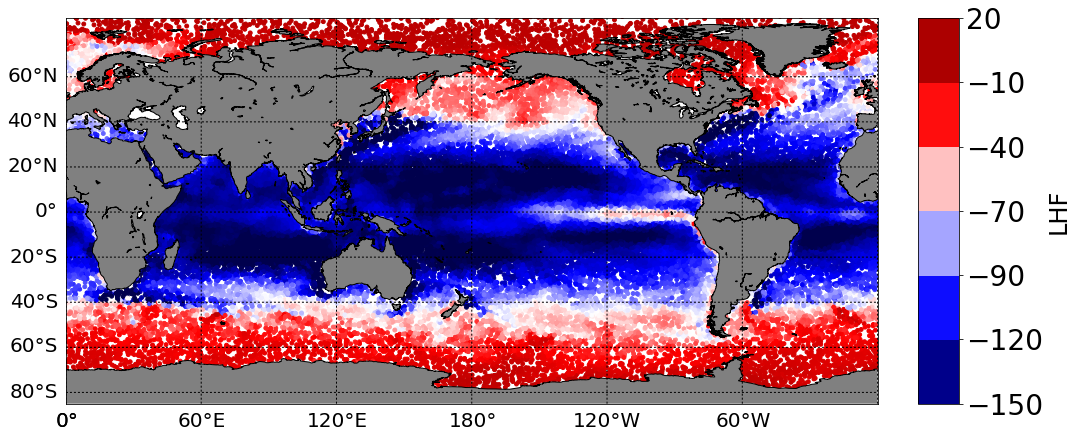

In [21]:
rtd = 180./np.pi
nskip = 5

field = dsGcase.timeMonthly_avg_latentHeatFlux[::nskip]  # change name of field to plot here.
cLabel = 'LHF' #colorbar label
minval = -150 #min bound of field to plot
maxval = 20   #max bound of field to plot

m = Basemap(projection='cyl', llcrnrlat=-85, urcrnrlat=86, llcrnrlon=0,
                        urcrnrlon=360, resolution='l')
x, y = m(dsBase.lonCell[::nskip].values*rtd, dsBase.latCell[::nskip].values*rtd)  # compute map proj coordinates

m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='white')
m.drawparallels(np.arange(-80., 80., 20.),fontsize=20,
                labels=[True, False, False, False]);
m.drawmeridians(np.arange(-180., 180., 60.),fontsize=20,
                labels=[False, False, False, True]);
    
if abs(maxval) > 10:
    rspot = -1
elif abs(maxval) > 1:
    rspot = 0
else:
    rspot = 2

minval = round(minval, rspot)
maxval = round(maxval, rspot)

tickbounds = np.linspace(minval,maxval,7)
for i in range(len(tickbounds)):
    tickbounds[i] = round(tickbounds[i],rspot)

cs = m.scatter(x,y,s=15,c=field, vmin = minval, vmax = maxval);
cbar = m.colorbar(cs, location='right', pad="5%", spacing='uniform', \
                 ticks=tickbounds, boundaries=tickbounds)
cbar.set_label(cLabel,fontsize=24)

/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


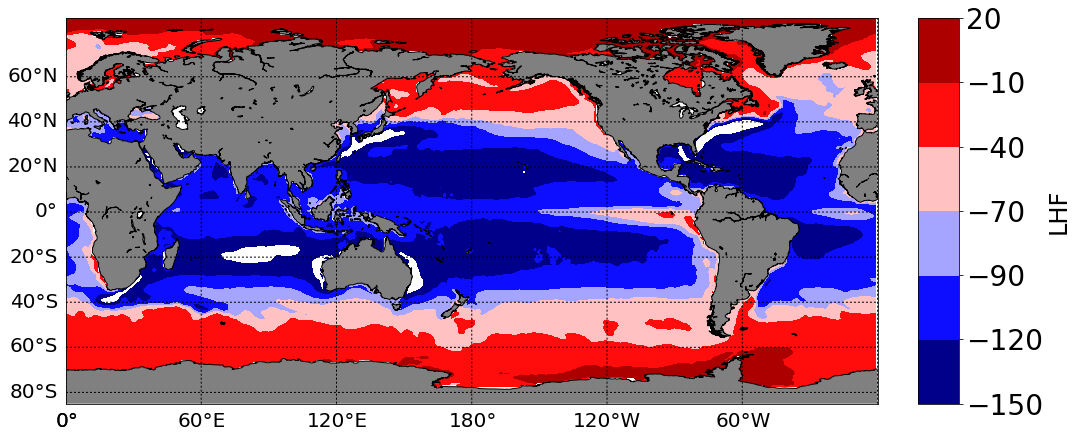

In [22]:
field = OAFluxFull[fieldDict[cLabel][1]].values
m = Basemap(projection='cyl', llcrnrlat=-85, urcrnrlat=86, llcrnrlon=0,
                        urcrnrlon=360, resolution='l')
x, y = m(OAFluxFull.lon[:].values, OAFluxFull.lat[:].values-89.5)  # compute map proj coordinates
xx, yy = meshgrid(x, y)

m.drawcoastlines()
m.fillcontinents(color='grey', lake_color='white')
m.drawparallels(np.arange(-80., 80., 20.),fontsize=20,
                labels=[True, False, False, False]);
m.drawmeridians(np.arange(-180., 180., 60.),fontsize=20,
                labels=[False, False, False, True]);

cs = m.contourf(xx,yy,field,levels=tickbounds);
cbar = m.colorbar(cs, location='right', pad="5%", spacing='uniform', \
                 ticks=tickbounds, boundaries=tickbounds)
cbar.set_label(cLabel,fontsize=24)